# PyTorch Basics Notebook
### Introduction to Tensors, Datasets, DataLoaders, CNNs, and U‑Net Building Blocks

## Import Required Libraries

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt


## PyTorch Tensors

In [21]:
# Creating tensors
x = torch.tensor([1.0, 2.0, 3.0])
y = torch.randn(3)  # random tensor

print(x)
print(y)

# Tensor operations
print('Addition:', x + y)
print('Mean:', x.mean())


tensor([1., 2., 3.])
tensor([-0.2765,  1.9336, -0.7817])
Addition: tensor([0.7235, 3.9336, 2.2183])
Mean: tensor(2.)


## Autograd Basics

In [22]:
# Enable gradient tracking
a = torch.tensor([2.0, 3.0], requires_grad=True)
b = (a * a).sum()
b.backward()
print(a.grad)  # derivative of x^2 is 2x


tensor([4., 6.])


## Custom PyTorch Dataset

We simulate MRI-like slices using random arrays just for practice.

In [23]:
class RandomMRIDataset(Dataset):
    def __init__(self, length=100):
        self.length = length

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        image = torch.randn(1, 64, 64)      # fake MRI slice
        mask = (torch.randn(1, 64, 64) > 0).float()  # fake mask
        return image, mask

dataset = RandomMRIDataset()
img, msk = dataset[0]
img.shape, msk.shape


(torch.Size([1, 64, 64]), torch.Size([1, 64, 64]))

## DataLoader

In [24]:
loader = DataLoader(dataset, batch_size=8, shuffle=True)

for images, masks in loader:
    print(images.shape, masks.shape)
    break


torch.Size([8, 1, 64, 64]) torch.Size([8, 1, 64, 64])


## Building a Simple CNN

In [25]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 16 * 16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        return self.classifier(x)

model = SimpleCNN()
print(model)


SimpleCNN(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=8192, out_features=1, bias=True)
    (2): Sigmoid()
  )
)


## Training Loop Example

In [26]:
model = SimpleCNN()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(2):
    for images, masks in loader:
        optimizer.zero_grad()
        preds = model(images)
        loss = criterion(preds, torch.zeros_like(preds))  # dummy target
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}')


Epoch 1, Loss: 0.0000
Epoch 2, Loss: 0.0000


## U‑Net Building Blocks

In [27]:
def conv_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU()
    )

sample = torch.randn(1, 1, 128, 128)
block = conv_block(1, 16)
output = block(sample)
output.shape


torch.Size([1, 16, 128, 128])

## Exercises


1. Modify `RandomMRIDataset` to return a resized (128×128) slice using interpolation.  
2. Add another convolution layer to `SimpleCNN` and observe how the model size changes.  
3. Implement a small encoder-decoder network (mini U-Net) using `conv_block`.  
4. Write a custom Dice Loss function in PyTorch.  
5. Train the CNN on the random dataset and plot the loss curve using matplotlib.  


In [28]:
import torch.nn.functional as F

In [31]:
class ModifiedMRIDataset(RandomMRIDataset):
    def __getitem__(self, idx):
        image, mask = super().__getitem__(idx)
        
        image = F.interpolate(
            image.unsqueeze(0),
            size=(128,128),
            mode='bilinear',
            align_corners=False
        ).squeeze(0)
        mask = F.interpolate(
            mask.unsqueeze(0),
            size=(128,128),
            mode='nearest'
        ).squeeze(0)
        
        return image, mask

In [32]:
class ExtendedCNN(SimpleCNN):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 16 * 16, 1),
            nn.Sigmoid()
        )

extended_model = ExtendedCNN()
print(extended_model)

ExtendedCNN(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=16384, out_features=1, bias=True)
    (2): Sigmoid()
  )
)


In [33]:
class MiniUNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc1 = conv_block(1, 16)
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = conv_block(16, 32)
        self.pool2 = nn.MaxPool2d(2)

        self.enc3 = conv_block(32, 64)
        self.pool3 = nn.MaxPool2d(2)

        self.bottleneck = conv_block(64, 128)

        self.up3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec3 = conv_block(128, 64)

        self.up2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.dec2 = conv_block(64, 32)

        self.up1 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)
        self.dec1 = conv_block(32, 16)

        self.out = nn.Conv2d(16, 1, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        p1 = self.pool1(e1)

        e2 = self.enc2(p1)
        p2 = self.pool2(e2)

        e3 = self.enc3(p2)
        p3 = self.pool3(e3)

        b = self.bottleneck(p3)

        u3 = self.up3(b)
        d3 = self.dec3(torch.cat([u3, e3], dim=1))

        u2 = self.up2(d3)
        d2 = self.dec2(torch.cat([u2, e2], dim=1))

        u1 = self.up1(d2)
        d1 = self.dec1(torch.cat([u1, e1], dim=1))

        return self.out(d1)

final_model = MiniUNet()
print(final_model)

x = torch.randn(1, 1, 128, 128)
y = final_model(x)
print("Output shape:", y.shape)

MiniUNet(
  (enc1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bottleneck): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (

In [34]:
class DiceLoss(nn.Module):
    def __init__(self, smooth: float = 1e-6, from_logits: bool = True):
        super().__init__()
        self.smooth = float(smooth)
        self.from_logits = from_logits

    def forward(self, inputs: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        if self.from_logits:
            inputs = torch.sigmoid(inputs)

        inputs_flat = inputs.view(inputs.size(0), -1)
        targets_flat = targets.view(targets.size(0), -1).float()

        intersection = (inputs_flat * targets_flat).sum(dim=1)
        cardinality = inputs_flat.sum(dim=1) + targets_flat.sum(dim=1)

        dice_score = (2.0 * intersection + self.smooth) / (cardinality + self.smooth)
        dice_loss = 1.0 - dice_score

        return dice_loss.mean()

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 8
lr = 1e-3
num_epochs = 5

In [36]:
dataset = ModifiedMRIDataset()
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [37]:
model = MiniUNet().to(device)
criterion = DiceLoss(from_logits=True)
optimizer = optim.Adam(model.parameters(), lr=lr)

In [38]:
epoch_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    iters = 0
    for images, masks in loader:
        images = images.to(device).float()
        masks = masks.to(device).float()
        if masks.ndim == 3:
            masks = masks.unsqueeze(1)

        optimizer.zero_grad()
        preds = model(images)
        loss = criterion(preds, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        iters += 1

    epoch_loss = running_loss / max(1, iters)
    epoch_losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs} — Loss: {epoch_loss:.6f}")

Epoch 1/5 — Loss: 0.473682
Epoch 2/5 — Loss: 0.331806
Epoch 3/5 — Loss: 0.334618
Epoch 4/5 — Loss: 0.334013
Epoch 5/5 — Loss: 0.333683


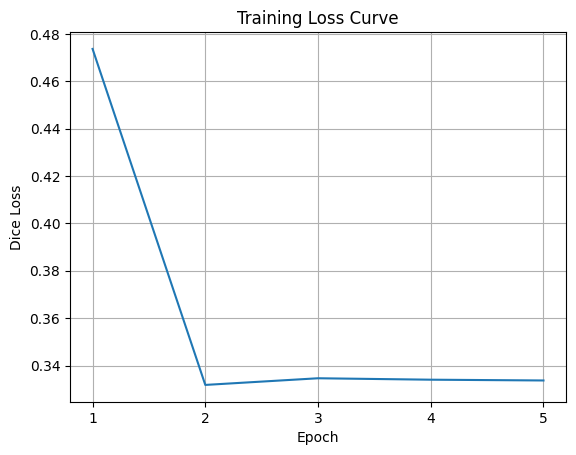

In [39]:
plt.figure()
plt.plot(range(1, len(epoch_losses)+1), epoch_losses)
plt.xlabel("Epoch")
plt.ylabel("Dice Loss")
plt.title("Training Loss Curve")
plt.grid(True)
plt.xticks(range(1, len(epoch_losses)+1))
plt.show()